In [180]:
import pandas as pd
import numpy as np
import os
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Optional, Set, Union
import unicodedata

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.entities.lineup import Lineup, Player, Position

from src.db.nst_db_utils import *
from src.db.nhl_db_utils import get_player_full_name, insert_player_data
from src.data_processing.nst_scraper import *
from src.data_processing.pbp_utils import *
from src.data_processing.game_utils import *
from src.data_processing.team_utils import *
from src.data_processing.player_utils import *

In [181]:
goalie_stats = get_goalie_stats(
    start_date="2024-10-01",
    end_date="2025-01-31",
    table_name="goalie_stats_5v5"
)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.


In [182]:
goalie_stats

,date,player,team,toi,shots_against,saves,goals_against,sv_pct,gaa,gsaa,xg_against,hd_shots_against,hd_saves,hd_goals_against,hdsv_pct,md_shots_against,md_saves,md_goals_against,mdsv_pct,ld_shots_against,ld_saves,ld_goals_against,ldsv_pct,rush_attempts_against,rebound_attempts_against,avg_shot_distance,avg_goal_distance
0,2025-01-31,Daniil Tarasov,CBJ,50.23,24,23,1,0.958,1.19,1.52,2.66,5,4,1,0.8,3,3,0,1.0,16,16,0,1.0,1,8,37.92,10.0
1,2025-01-31,Thatcher Demko,VAN,46.75,12,10,2,0.833,2.57,-0.74,1.54,5,3,2,0.6,2,2,0,1.0,5,5,0,1.0,3,3,31.0,11.0
2,2025-01-31,Mackenzie Blackwood,COL,49.57,16,16,0,1.0,0.0,1.68,1.35,3,3,0,1.0,6,6,0,1.0,7,7,0,1.0,4,2,31.81,NaN
3,2025-01-31,Karel Vejmelka,UTA,50.23,16,14,2,0.875,2.39,-0.32,0.96,2,1,1,0.5,2,2,0,1.0,11,10,1,0.909,0,2,42.13,21.0
4,2025-01-31,Jake Oettinger,DAL,46.75,17,15,2,0.882,2.57,-0.22,1.39,4,3,1,0.75,0,0,0,NaN,11,10,1,0.909,1,2,51.24,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,2024-10-08,Petr Mrazek,CHI,50.7,24,20,4,0.833,4.73,-1.15,2.57,9,7,2,0.778,8,7,1,0.875,6,5,1,0.833,1,6,33.29,26.25
1726,2024-10-05,Devon Levi,BUF,45.43,26,24,2,0.923,2.64,-0.14,2.54,6,4,2,0.667,7,7,0,1.0,12,12,0,1.0,3,6,31.0,11.0
1727,2024-10-05,Jake Allen,NJD,45.43,16,15,1,0.938,1.32,0.14,1.39,3,2,1,0.667,1,1,0,1.0,11,11,0,1.0,1,4,46.19,7.0
1728,2024-10-04,Jacob Markstrom,NJD,46.72,26,25,1,0.962,1.28,1.31,2.59,5,4,1,0.8,5,5,0,1.0,15,15,0,1.0,3,7,41.46,16.0


In [183]:
db_prefix = 'NHL_DB_'

def extract_team_goalies(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# col_lineup = extract_team_lineup('COL', '2024-12-10')

In [184]:
def get_pregame_matchup_stats(input_date: str, team: str, last_n: int=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Retrieves and compiles pre-game statistics for both teams in a matchup.
    
    This function performs the following steps:
    1. Calculates reference date and retrieves team statistics
    2. Identifies the matchup game and opponent team
    3. Compiles team-level statistics for both teams
    4. Identifies starting goalies for both teams
    
    Args:
        input_date (str): The game date in 'YYYY-MM-DD' format
        team (str): The three-letter team code (e.g., 'TOR')
        last_n (int, optional): Number of previous games to consider for team statistics
        team_stats_df (pd.DataFrame, optional): Pre-loaded team statistics DataFrame. If None, will fetch new data
    
    Returns:
        pd.DataFrame: A DataFrame with two rows (one per team) containing:
            - Game context (date, game_id, home/away)
            - Team statistics
            - Starting goalie information (name, team, id)
    """
    try:
        # Step 1a: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If team_stats_df is not provided, fetch them
        if team_stats_df is None or team_stats_df.empty:
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                stype=2,
                sit='all',
                last_n=last_n
            )

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None
        side = None

         # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                side = 'A'
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                side = 'H'
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")
        
        # Step 5: Get full names for both teams
        team_fullname = get_fullname_by_tricode(team)
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)

        if team_fullname is None or opponent_team_fullname is None:
            raise ValueError(f"Could not find full names for teams: {team} or {opponent_team_tricode}")
        
        # Remove accent marks and punctuation from both team names
        team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        
        # Create matchup DataFrame - Modified section
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in team_stats_df. Please verify the scraped data.")

        # Filter stats for both teams
        team_row = team_stats_df[team_stats_df['team'].str.lower() == team_fullname.lower()]
        opponent_row = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        
        if team_row.empty or opponent_row.empty:
            raise ValueError(f"Could not find statistics for one or both teams")
            
        # Create a new DataFrame with team names but opponent stats
        matchup_df = pd.DataFrame()
        
        # First row: Keep team name but use opponent's stats
        first_row = opponent_row.copy()
        first_row['team'] = team
        
        # Second row: Keep opponent name but use team's stats
        second_row = team_row.copy()
        second_row['team'] = opponent_team_tricode
        
        # Combine rows
        matchup_df = pd.concat([first_row, second_row])
        
        # Add additional context columns
        matchup_df['home'] = [side == 'H', side == 'A']
        matchup_df['game_id'] = game_id
        matchup_df['game_date'] = input_date
        matchup_df['b2b'] = [team_b2b, opponent_b2b]  # First row has team's b2b, second row has opponent's b2b
        matchup_df['opp_b2b'] = [opponent_b2b, team_b2b]  # First row has opponent's b2b, second row has team's b2b

        # Convert team names to tricodes
        matchup_df['team'] = [team, opponent_team_tricode]

        # Drop specified columns
        columns_to_drop = ['gp', 'toi', 'w', 'l', 'otl', 'row', 'points', 'point_%']
        matchup_df = matchup_df.drop(columns=columns_to_drop, errors='ignore')

        # Reorder columns to put game_date and game_id first
        cols = matchup_df.columns.tolist()
        cols = ['game_date', 'game_id', 'home'] + [col for col in cols if col not in ['game_date', 'game_id', 'home']]
        matchup_df = matchup_df[cols]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
    
        # Get goalie information for both teams
        goalie_info = []
        for idx, row in matchup_df.iterrows():
            try:
                # If the game is in the past, just read the goalie from the boxscore
                if input_date < datetime.now().strftime('%Y-%m-%d'):
                    boxscore = get_game_boxscore(row['game_id'], clean=False)
                    # Use awayTeam for first row (idx=0), homeTeam for second row (idx=1)
                    team_type = 'awayTeam' if idx == 0 else 'homeTeam'
                    goalies = boxscore['playerByGameStats'][team_type]['goalies']
                    
                    if goalies:
                        # Sort goalies by TOI (descending) and take the one with most ice time
                        starting_goalie = max(goalies, key=lambda x: x.get('toi', '00:00'))
                        if starting_goalie.get('toi') != '00:00':
                            goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            if goalie_name is None:
                                player_data = fetch_player_data(starting_goalie.get('playerId'))
                                if player_data:
                                    insert_player_data(player_data, 'NHL_DB_')
                                goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            goalie_info.append({
                                'goalie_name': goalie_name,
                                'goalie_team': row['team'],
                                'goalie_id': starting_goalie.get('playerId')
                            })
                        else:
                            goalie_info.append({
                                'goalie_name': None,
                                'goalie_team': None,
                                'goalie_id': None
                            })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
                else:
                    lineup = extract_team_goalies(row['team'], input_date)
                    if lineup.goalies[0] is not None:  # Get starting goalie
                        goalie = lineup.goalies[0]
                        goalie_info.append({
                            'goalie_name': goalie.name,
                            'goalie_team': goalie.team,
                            'goalie_id': goalie.player_id
                        })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
            except Exception as e:
                print(f"Error getting goalie for {row['team']}: {e}")
                goalie_info.append({
                    'goalie_name': None,
                    'goalie_team': None,
                    'goalie_id': None
                })
        
        # Add goalie information to matchup_df
        for col in ['goalie_name', 'goalie_team', 'goalie_id']:
            matchup_df[col] = [info[col] for info in goalie_info]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
        
        return matchup_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# # Example usage of the process_team_and_opponent function
input_date = '2025-02-08'
team = 'CHI'  # Example team code
matchup_data = get_pregame_matchup_stats(input_date, team, last_n=14)

Fetching data for reference date: 2025-02-07
Retrieving matchup games for date 2025-02-08.
Checking Game ID: 2024020876 on Date: 2025-02-08
Away Team: NJD, Home Team: MTL
Checking Game ID: 2024020877 on Date: 2025-02-08
Away Team: TBL, Home Team: DET
Checking Game ID: 2024020878 on Date: 2025-02-08
Away Team: UTA, Home Team: CAR
Checking Game ID: 2024020879 on Date: 2025-02-08
Away Team: VGK, Home Team: BOS
Checking Game ID: 2024020880 on Date: 2025-02-08
Away Team: OTT, Home Team: FLA
Checking Game ID: 2024020881 on Date: 2025-02-08
Away Team: PIT, Home Team: PHI
Checking Game ID: 2024020882 on Date: 2025-02-08
Away Team: NYR, Home Team: CBJ
Checking Game ID: 2024020883 on Date: 2025-02-08
Away Team: CHI, Home Team: STL
Team CHI found as Away Team in Game ID 2024020883. Opponent TriCode: STL


In [185]:
matchup_data

,game_date,game_id,home,team,cf,ca,cf%,ff,fa,ff%,sf,sa,sf%,gf,ga,gf%,xgf,xga,xgf%,scf,sca,scf%,scsf,scsa,scsf%,scgf,scga,scgf%,scsh%,scsv%,hdcf,hdca,hdcf%,hdsf,hdsa,hdsf%,hdgf,hdga,hdgf%,hdsh%,hdsv%,mdcf,mdca,mdcf%,mdsf,mdsa,mdsf%,mdgf,mdga,mdgf%,mdsh%,mdsv%,ldcf,ldca,ldcf%,ldsf,ldsa,ldsf%,ldgf,ldga,ldgf%,ldsh%,ldsv%,sh%,sv%,pdo,b2b,opp_b2b,goalie_name,goalie_team,goalie_id
0,2025-02-08,2024020883,False,CHI,316,345,47.81,230,265,46.46,151,183,45.21,8,19,29.63,16.74,19.24,46.53,153,170,47.37,82,88,48.24,6,15,28.57,7.32,82.95,59,73,44.70,33,42,44.00,3,7,30.0,9.09,83.33,94,97,49.21,49,46,51.58,3,8,27.27,6.12,82.61,196,198,49.75,60,83,41.96,2,3,40.00,3.33,96.39,5.30,89.62,0.949,1,0,Arvid Soderblom,CHI,8482821
1,2025-02-08,2024020883,True,STL,343,446,43.47,254,337,42.98,162,245,39.80,21,23,47.73,17.08,26.20,39.47,165,232,41.56,89,139,39.04,16,20,44.44,17.98,85.61,63,104,37.72,42,77,35.29,9,15,37.5,21.43,80.52,102,128,44.35,47,62,43.12,7,5,58.33,14.89,91.94,201,246,44.97,64,98,39.51,4,2,66.67,6.25,97.96,12.96,90.61,1.036,0,1,Jordan Binnington,STL,8476412


In [186]:
def calculate_goalie_rolling_stats(df, player_name: str, window_size: int = 10, date: str = None):
    """Create rolling averages and statistics for a specific goalie
    
    Args:
        df (pd.DataFrame): Input dataframe with goalie statistics
        player_name (str): Name of the player to process
        window_size (int, optional): Size of rolling window for statistics. Defaults to 10.
        date (str, optional): If provided, filter out data on or after this date
        
    Returns:
        pd.DataFrame: Processed statistics for the specified player or league averages if player not found
    """
    # Make a copy and filter for specific player
    player_df = df[df['player'] == player_name].copy()
    
    # If no data found for player, use league averages
    if player_df.empty:
        print(f"No data found for player: {player_name}. Using league averages.")
        
        # Calculate league averages
        league_df = df.copy()
        league_df['date'] = pd.to_datetime(league_df['date'])
        
        if date:
            cutoff_date = pd.to_datetime(date)
            league_df = league_df[league_df['date'] < cutoff_date]
        
        # Convert numeric columns from object to float
        numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                       'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
        for col in numeric_cols:
            league_df[col] = pd.to_numeric(league_df[col], errors='coerce')
        
        # Calculate league averages for all relevant columns
        feature_columns = [
            'shots_against', 'sv_pct', 'gaa', 'gsaa',
            'xg_against', 
            'hd_shots_against', 'hdsv_pct',
            'md_shots_against', 'mdsv_pct',
            'ld_shots_against', 'ldsv_pct'
        ]
        
        # Create a single row DataFrame with league averages
        league_averages = pd.DataFrame([{
            f'{col}_rolling_avg': league_df[col].mean() for col in feature_columns
        }])
        
        # Add standard deviations
        for col in feature_columns:
            league_averages[f'{col}_rolling_std'] = league_df[col].std()
        
        # Add workload features (use median values)
        league_averages['days_rest'] = 3.0  # typical rest between games
        league_averages['games_last_7'] = 2.0  # typical games in 7 days
        
        return league_averages
    
    # If we have player data, proceed with normal calculations
    player_df['date'] = pd.to_datetime(player_df['date'])
    player_df = player_df.sort_values('date')
    
    # Convert numeric columns from object to float
    numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                   'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
    for col in numeric_cols:
        player_df[col] = pd.to_numeric(player_df[col], errors='coerce')
    
    feature_columns = [
        'shots_against', 'sv_pct', 'gaa', 'gsaa',
        'xg_against', 
        'hd_shots_against', 'hdsv_pct',
        'md_shots_against', 'mdsv_pct',
        'ld_shots_against', 'ldsv_pct'
    ]
    
    try:
        print(f"Processing player: {player_name}")
        print(f"Data shape: {player_df.shape}")
        
        # Calculate rolling statistics
        for col in feature_columns:
            player_df[f'{col}_rolling_avg'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).mean()
            player_df[f'{col}_rolling_std'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).std()
        
        # Add workload features
        player_df['days_rest'] = player_df['date'].diff().dt.days
        player_df['games_last_7'] = player_df.rolling('7D', on='date')['date'].count()
        
        print(f"Successfully processed {player_name}")
        
        # Filter out dates if date is provided
        if date:
            cutoff_date = pd.to_datetime(date)
            player_df = player_df[player_df['date'] < cutoff_date]
            if player_df.empty:
                print(f"No data found for {player_name} before {date}. Using league averages.")
                return calculate_goalie_rolling_stats(df, player_name, window_size)  # Recursive call without date
            player_df = player_df.tail(1).reset_index(drop=True)

        # Keep only date, rolling features, and workload features
        rolling_cols = [col for col in player_df.columns if 'rolling' in col]
        cols_to_keep = ['date', 'player', 'team'] + rolling_cols + ['days_rest', 'games_last_7']
        player_df = player_df[cols_to_keep]
            
        return player_df
        
    except Exception as e:
        print(f"Error processing player {player_name}: {str(e)}")
        print("Data types:", player_df.dtypes)
        raise

In [187]:
def enrich_matchup_with_goalie_stats(
    matchup_df: pd.DataFrame,
    goalie_stats_df: pd.DataFrame,
    window_size: int = 10
) -> pd.DataFrame:
    """
    Enriches matchup data with rolling goalie statistics.
    
    Args:
        matchup_df (pd.DataFrame): Output from get_pregame_matchup_stats
        goalie_stats_df (pd.DataFrame): Raw goalie statistics
        window_size (int): Window size for rolling calculations
        
    Returns:
        pd.DataFrame: Enhanced matchup data with goalie rolling statistics
    """
    # Create a copy to avoid modifying original
    enriched_df = matchup_df.copy()
    
    # Process each goalie in the matchup
    for idx, row in enriched_df.iterrows():
        if pd.isna(row['goalie_name']):
            continue
            
        try:
            # Calculate rolling stats for this goalie
            goalie_rolling_stats = calculate_goalie_rolling_stats(
                goalie_stats_df,
                player_name=row['goalie_name'],
                window_size=window_size,
                date=row['game_date']
            )
            
            if not goalie_rolling_stats.empty:
                # Add prefix to rolling columns to avoid confusion with team stats
                rolling_cols = [col for col in goalie_rolling_stats.columns 
                              if col not in ['date', 'player', 'team']]
                
                for col in rolling_cols:
                    enriched_df.at[idx, f'g_{col}'] = goalie_rolling_stats.iloc[0][col]
                    
        except Exception as e:
            print(f"Error processing goalie {row['goalie_name']}: {e}")
            # Continue with next goalie if one fails
            continue
    
    return enriched_df

# matchup_data = enrich_matchup_with_goalie_stats(matchup_data, goalie_stats)

In [188]:
def get_matchup_goalie_results(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Retrieves actual game results for goalies from a matchup DataFrame.
    
    Args:
        matchup_df (pd.DataFrame): DataFrame containing matchup data with game_id column
        
    Returns:
        pd.DataFrame: Original matchup data with additional columns for actual game results
    """
    # Get the boxscore data
    game_id = matchup_df['game_id'].iloc[0]
    game_data = get_game_boxscore(game_id, clean=False)
    player_stats = game_data.get('playerByGameStats', {})
    
    # Create a copy of the input DataFrame
    enriched_df = matchup_df.copy()
    
    # Process each team's data
    for idx, row in enriched_df.iterrows():
        team_type = 'homeTeam' if row['home'] else 'awayTeam'
        goalies = player_stats.get(team_type, {}).get('goalies', [])
        
        if goalies:
            # Find the goalie whose name matches the one in enriched_df
            matching_goalie = None
            for g in goalies:
                goalie_name = get_player_full_name(g.get('playerId'), 'NHL_DB_', suppress_log=True)
                if goalie_name == row['goalie_name']:
                    matching_goalie = g
                    break
            
            # If no matching goalie found, use the first one (as before)
            goalie = matching_goalie or goalies[0]
            
            shots = goalie.get('shotsAgainst', 0)
            saves = goalie.get('saves', 0)
            
            enriched_df.loc[idx, 'res_saves'] = saves
            enriched_df.loc[idx, 'res_shots_against'] = shots
            enriched_df.loc[idx, 'res_save_pct'] = round(saves / shots if shots > 0 else 0.0, 3)
            enriched_df.loc[idx, 'res_goals_against'] = goalie.get('goalsAgainst', 0)
            enriched_df.loc[idx, 'res_decision'] = goalie.get('decision', 'N/A')
    
    return enriched_df

In [189]:
def process_matchups_for_date(input_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by getting matchup stats, 
    enriching with goalie stats, and getting actual game results.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date with 
                     pre-game stats and actual results
    """
    try:
        # Step 1: Get matchup games for the date
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        
        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        # Step 2: Get goalie stats for enrichment
        goalie_stats = get_goalie_stats(
            end_date=input_date,
            table_name="goalie_stats_5v5"
        )

        # Get team stats for matchup date so they are not scraped each time
        team_stats_df = nst_team_on_ice_scraper(
            startdate='',
            enddate=input_date,
            stype=2,
            sit='all',
            last_n=last_n
        )

        results = []
        
        # Step 3: Process each game
        for game_id in game_ids:
            print(f"\nProcessing Game ID: {game_id}")
            
            # Get boxscore to determine teams
            boxscore = get_game_boxscore(game_id, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            
            if not away_team or not home_team:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue
                
            # Process away team
            try:
                matchup = get_pregame_matchup_stats(input_date, away_team, last_n=last_n, team_stats_df=team_stats_df)
                matchup = enrich_matchup_with_goalie_stats(matchup, goalie_stats)
                matchup = get_matchup_goalie_results(matchup)
                results.append(matchup)
            except Exception as e:
                print(f"Error processing away team {away_team}: {e}")

        # Combine all results
        if results:
            final_df = pd.concat(results, ignore_index=True)
            print("\nAll matchups processed successfully.")
            return final_df
        else:
            print("No matchups were successfully processed.")
            return pd.DataFrame()

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [190]:
# matchups = process_matchups_for_date('2024-12-10', last_n=15)

In [191]:
def process_matchups_for_date_range(start_date: str, end_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes matchup games for a range of dates by calling process_matchups_for_date for each date.
    
    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date range with 
                     pre-game stats and actual results
    """
    try:
        # Convert dates to datetime objects
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        
        # Generate list of dates
        dates = pd.date_range(start=start, end=end, freq='D')
        
        all_results = []
        
        # Process each date
        for date in dates:
            date_str = date.strftime('%Y-%m-%d')
            print(f"\nProcessing date: {date_str}")
            
            # Process matchups for this date
            daily_results = process_matchups_for_date(date_str, last_n=last_n)
            if not daily_results.empty:
                all_results.append(daily_results)

            time.sleep(random.randint(45, 60))
        
        # Combine all results
        if all_results:
            final_df = pd.concat(all_results, ignore_index=True)
            print(f"\nProcessed {len(dates)} days of matchups successfully.")
            return final_df
        else:
            print("No matchups were successfully processed for the date range.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# Example usage:
matchups_range = process_matchups_for_date_range('2023-10-10', '2023-10-31', last_n=15)


Processing date: 2023-10-10


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020001
Fetching data for reference date: 2023-10-09
Retrieving matchup games for date 2023-10-10.
Checking Game ID: 2023020001 on Date: 2023-10-10
Away Team: NSH, Home Team: TBL
Team NSH found as Away Team in Game ID 2023020001. Opponent TriCode: TBL
Processing player: Juuse Saros
Data shape: (59, 27)
Successfully processed Juuse Saros
Processing player: Jonas Johansson
Data shape: (3, 27)
Successfully processed Jonas Johansson

Processing Game ID: 2023020002
Fetching data for reference date: 2023-10-09
Retrieving matchup games for date 2023-10-10.
Checking Game ID: 2023020001 on Date: 2023-10-10
Away Team: NSH, Home Team: TBL
Checking Game ID: 2023020002 on Date: 2023-10-10
Away Team: CHI, Home Team: PIT
Team CHI found as Away Team in Game ID 2023020002. Opponent TriCode: PIT
Processing player: Petr Mrazek
Data shape: (38, 27)
Successfully processed Petr Mrazek
Processing player: Tristan Jarry
Data shape: (44, 27)
Successfully processed Tristan Jarry

Processi

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020004
Fetching data for reference date: 2023-10-10
Retrieving matchup games for date 2023-10-11.
Checking Game ID: 2023020004 on Date: 2023-10-11
Away Team: OTT, Home Team: CAR
Team OTT found as Away Team in Game ID 2023020004. Opponent TriCode: CAR
Processing player: Joonas Korpisalo
Data shape: (36, 27)
Successfully processed Joonas Korpisalo
Processing player: Frederik Andersen
Data shape: (35, 27)
Successfully processed Frederik Andersen

Processing Game ID: 2023020005
Fetching data for reference date: 2023-10-10
Retrieving matchup games for date 2023-10-11.
Checking Game ID: 2023020004 on Date: 2023-10-11
Away Team: OTT, Home Team: CAR
Checking Game ID: 2023020005 on Date: 2023-10-11
Away Team: MTL, Home Team: TOR
Team MTL found as Away Team in Game ID 2023020005. Opponent TriCode: TOR
Processing player: Jake Allen
Data shape: (39, 27)
Successfully processed Jake Allen
Processing player: Ilya Samsonov
Data shape: (41, 27)
Successfully processed Ilya Samso

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020010
Fetching data for reference date: 2023-10-11
Retrieving matchup games for date 2023-10-12.
Checking Game ID: 2023020010 on Date: 2023-10-12
Away Team: NYR, Home Team: BUF
Team NYR found as Away Team in Game ID 2023020010. Opponent TriCode: BUF
Processing player: Igor Shesterkin
Data shape: (55, 27)
Successfully processed Igor Shesterkin
Processing player: Devon Levi
Data shape: (8, 27)
Successfully processed Devon Levi

Processing Game ID: 2023020011
Fetching data for reference date: 2023-10-11
Retrieving matchup games for date 2023-10-12.
Checking Game ID: 2023020010 on Date: 2023-10-12
Away Team: NYR, Home Team: BUF
Checking Game ID: 2023020011 on Date: 2023-10-12
Away Team: PHI, Home Team: CBJ
Team PHI found as Away Team in Game ID 2023020011. Opponent TriCode: CBJ
Processing player: Carter Hart
Data shape: (52, 27)
Successfully processed Carter Hart
Processing player: Elvis Merzlikins
Data shape: (30, 27)
Successfully processed Elvis Merzlikins

Proc

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020017
Fetching data for reference date: 2023-10-12
Retrieving matchup games for date 2023-10-13.
Checking Game ID: 2023020017 on Date: 2023-10-13
Away Team: ARI, Home Team: NJD
Team ARI found as Away Team in Game ID 2023020017. Opponent TriCode: NJD
Processing player: Karel Vejmelka
Data shape: (46, 27)
Successfully processed Karel Vejmelka
Processing player: Akira Schmid
Data shape: (19, 27)
Successfully processed Akira Schmid

Processing Game ID: 2023020018
Fetching data for reference date: 2023-10-12
Retrieving matchup games for date 2023-10-13.
Checking Game ID: 2023020017 on Date: 2023-10-13
Away Team: ARI, Home Team: NJD
Checking Game ID: 2023020018 on Date: 2023-10-13
Away Team: PIT, Home Team: WSH
Team PIT found as Away Team in Game ID 2023020018. Opponent TriCode: WSH
Processing player: Tristan Jarry
Data shape: (45, 27)
Successfully processed Tristan Jarry
Processing player: Charlie Lindgren
Data shape: (29, 27)
Successfully processed Charlie Lindgre

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020019
Fetching data for reference date: 2023-10-13
Retrieving matchup games for date 2023-10-14.
Checking Game ID: 2023020019 on Date: 2023-10-14
Away Team: PHI, Home Team: OTT
Team PHI found as Away Team in Game ID 2023020019. Opponent TriCode: OTT
Processing player: Carter Hart
Data shape: (53, 27)
Successfully processed Carter Hart
Processing player: Anton Forsberg
Data shape: (29, 27)
Successfully processed Anton Forsberg

Processing Game ID: 2023020020
Fetching data for reference date: 2023-10-13
Retrieving matchup games for date 2023-10-14.
Checking Game ID: 2023020019 on Date: 2023-10-14
Away Team: PHI, Home Team: OTT
Checking Game ID: 2023020020 on Date: 2023-10-14
Away Team: FLA, Home Team: WPG
Team FLA found as Away Team in Game ID 2023020020. Opponent TriCode: WPG
Processing player: Sergei Bobrovsky
Data shape: (48, 27)
Successfully processed Sergei Bobrovsky
Processing player: Connor Hellebuyck
Data shape: (61, 27)
Successfully processed Connor Hel

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020033
Fetching data for reference date: 2023-10-14
Retrieving matchup games for date 2023-10-15.
Checking Game ID: 2023020033 on Date: 2023-10-15
Away Team: TBL, Home Team: OTT
Team TBL found as Away Team in Game ID 2023020033. Opponent TriCode: OTT
Processing player: Matt Tomkins
Data shape: (1, 27)
Successfully processed Matt Tomkins
No data found for Matt Tomkins before 2023-10-15. Using league averages.
Processing player: Matt Tomkins
Data shape: (1, 27)
Successfully processed Matt Tomkins
Processing player: Joonas Korpisalo
Data shape: (37, 27)
Successfully processed Joonas Korpisalo

Processing Game ID: 2023020034
Fetching data for reference date: 2023-10-14
Retrieving matchup games for date 2023-10-15.
Checking Game ID: 2023020033 on Date: 2023-10-15
Away Team: TBL, Home Team: OTT
Checking Game ID: 2023020034 on Date: 2023-10-15
Away Team: CAR, Home Team: ANA
Team CAR found as Away Team in Game ID 2023020034. Opponent TriCode: ANA
Processing player: Ant

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020035
Fetching data for reference date: 2023-10-15
Retrieving matchup games for date 2023-10-16.
Checking Game ID: 2023020035 on Date: 2023-10-16
Away Team: DET, Home Team: CBJ
Team DET found as Away Team in Game ID 2023020035. Opponent TriCode: CBJ
Processing player: James Reimer
Data shape: (40, 27)
Successfully processed James Reimer
Processing player: Spencer Martin
Data shape: (27, 27)
Successfully processed Spencer Martin

Processing Game ID: 2023020036
Fetching data for reference date: 2023-10-15
Retrieving matchup games for date 2023-10-16.
Checking Game ID: 2023020035 on Date: 2023-10-16
Away Team: DET, Home Team: CBJ
Checking Game ID: 2023020036 on Date: 2023-10-16
Away Team: FLA, Home Team: NJD
Team FLA found as Away Team in Game ID 2023020036. Opponent TriCode: NJD
Processing player: Sergei Bobrovsky
Data shape: (49, 27)
Successfully processed Sergei Bobrovsky
Processing player: Vitek Vanecek
Data shape: (50, 27)
Successfully processed Vitek Vanece

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020042
Fetching data for reference date: 2023-10-16
Retrieving matchup games for date 2023-10-17.
Checking Game ID: 2023020042 on Date: 2023-10-17
Away Team: VAN, Home Team: PHI
Team VAN found as Away Team in Game ID 2023020042. Opponent TriCode: PHI
Processing player: Thatcher Demko
Data shape: (33, 27)
Successfully processed Thatcher Demko
Processing player: Carter Hart
Data shape: (54, 27)
Successfully processed Carter Hart

Processing Game ID: 2023020041
Fetching data for reference date: 2023-10-16
Retrieving matchup games for date 2023-10-17.
Checking Game ID: 2023020042 on Date: 2023-10-17
Away Team: VAN, Home Team: PHI
Checking Game ID: 2023020041 on Date: 2023-10-17
Away Team: MIN, Home Team: MTL
Team MIN found as Away Team in Game ID 2023020041. Opponent TriCode: MTL
Processing player: Marc-Andre Fleury
Data shape: (44, 27)
Successfully processed Marc-Andre Fleury
Processing player: Sam Montembeault
Data shape: (39, 27)
Successfully processed Sam Monte

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020049
Fetching data for reference date: 2023-10-17
Retrieving matchup games for date 2023-10-18.
Checking Game ID: 2023020049 on Date: 2023-10-18
Away Team: WSH, Home Team: OTT
Team WSH found as Away Team in Game ID 2023020049. Opponent TriCode: OTT
Processing player: Darcy Kuemper
Data shape: (55, 27)
Successfully processed Darcy Kuemper
Processing player: Anton Forsberg
Data shape: (30, 27)
Successfully processed Anton Forsberg

Processing Game ID: 2023020050
Fetching data for reference date: 2023-10-17
Retrieving matchup games for date 2023-10-18.
Checking Game ID: 2023020049 on Date: 2023-10-18
Away Team: WSH, Home Team: OTT
Checking Game ID: 2023020050 on Date: 2023-10-18
Away Team: PIT, Home Team: DET
Team PIT found as Away Team in Game ID 2023020050. Opponent TriCode: DET
Processing player: Tristan Jarry
Data shape: (46, 27)
Successfully processed Tristan Jarry
Processing player: Ville Husso
Data shape: (56, 27)
Successfully processed Ville Husso

All m

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020051
Fetching data for reference date: 2023-10-18
Retrieving matchup games for date 2023-10-19.
Checking Game ID: 2023020051 on Date: 2023-10-19
Away Team: CGY, Home Team: BUF
Team CGY found as Away Team in Game ID 2023020051. Opponent TriCode: BUF
Processing player: Dan Vladar
Data shape: (26, 27)
Successfully processed Dan Vladar
Processing player: Devon Levi
Data shape: (11, 27)
Successfully processed Devon Levi

Processing Game ID: 2023020052
Fetching data for reference date: 2023-10-18
Retrieving matchup games for date 2023-10-19.
Checking Game ID: 2023020051 on Date: 2023-10-19
Away Team: CGY, Home Team: BUF
Checking Game ID: 2023020052 on Date: 2023-10-19
Away Team: TOR, Home Team: FLA
Team TOR found as Away Team in Game ID 2023020052. Opponent TriCode: FLA
Processing player: Ilya Samsonov
Data shape: (43, 27)
Successfully processed Ilya Samsonov
Processing player: Sergei Bobrovsky
Data shape: (50, 27)
Successfully processed Sergei Bobrovsky

Processin

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020063
Fetching data for reference date: 2023-10-19
Retrieving matchup games for date 2023-10-20.
Checking Game ID: 2023020063 on Date: 2023-10-20
Away Team: CGY, Home Team: CBJ
Team CGY found as Away Team in Game ID 2023020063. Opponent TriCode: CBJ
Processing player: Jacob Markstrom
Data shape: (58, 27)
Successfully processed Jacob Markstrom
Processing player: Spencer Martin
Data shape: (28, 27)
Successfully processed Spencer Martin

Processing Game ID: 2023020064
Fetching data for reference date: 2023-10-19
Retrieving matchup games for date 2023-10-20.
Checking Game ID: 2023020063 on Date: 2023-10-20
Away Team: CGY, Home Team: CBJ
Checking Game ID: 2023020064 on Date: 2023-10-20
Away Team: NJD, Home Team: NYI
Team NJD found as Away Team in Game ID 2023020064. Opponent TriCode: NYI
Processing player: Akira Schmid
Data shape: (20, 27)
Successfully processed Akira Schmid
Processing player: Ilya Sorokin
Data shape: (60, 27)
Successfully processed Ilya Sorokin

A

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020065
Fetching data for reference date: 2023-10-20
Retrieving matchup games for date 2023-10-21.
Checking Game ID: 2023020065 on Date: 2023-10-21
Away Team: DET, Home Team: OTT
Team DET found as Away Team in Game ID 2023020065. Opponent TriCode: OTT
Processing player: Ville Husso
Data shape: (57, 27)
Successfully processed Ville Husso
Processing player: Joonas Korpisalo
Data shape: (38, 27)
Successfully processed Joonas Korpisalo

Processing Game ID: 2023020066
Fetching data for reference date: 2023-10-20
Retrieving matchup games for date 2023-10-21.
Checking Game ID: 2023020065 on Date: 2023-10-21
Away Team: DET, Home Team: OTT
Checking Game ID: 2023020066 on Date: 2023-10-21
Away Team: ANA, Home Team: ARI
Team ANA found as Away Team in Game ID 2023020066. Opponent TriCode: ARI
Processing player: Lukas Dostal
Data shape: (18, 27)
Successfully processed Lukas Dostal
Processing player: Karel Vejmelka
Data shape: (48, 27)
Successfully processed Karel Vejmelka

P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020080
Fetching data for reference date: 2023-10-21
Retrieving matchup games for date 2023-10-22.
Checking Game ID: 2023020080 on Date: 2023-10-22
Away Team: CGY, Home Team: DET
Team CGY found as Away Team in Game ID 2023020080. Opponent TriCode: DET
Processing player: Dan Vladar
Data shape: (27, 27)
Successfully processed Dan Vladar
Processing player: James Reimer
Data shape: (41, 27)
Successfully processed James Reimer

Processing Game ID: 2023020081
Fetching data for reference date: 2023-10-21
Retrieving matchup games for date 2023-10-22.
Checking Game ID: 2023020080 on Date: 2023-10-22
Away Team: CGY, Home Team: DET
Checking Game ID: 2023020081 on Date: 2023-10-22
Away Team: BOS, Home Team: ANA
Team BOS found as Away Team in Game ID 2023020081. Opponent TriCode: ANA
Processing player: Linus Ullmark
Data shape: (48, 27)
Successfully processed Linus Ullmark
Processing player: John Gibson
Data shape: (53, 27)
Successfully processed John Gibson

All matchups pr

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020082
Fetching data for reference date: 2023-10-22
Retrieving matchup games for date 2023-10-23.
Checking Game ID: 2023020082 on Date: 2023-10-23
Away Team: MTL, Home Team: BUF
Team MTL found as Away Team in Game ID 2023020082. Opponent TriCode: BUF
Processing player: Jake Allen
Data shape: (41, 27)
Successfully processed Jake Allen
Processing player: Eric Comrie
Data shape: (20, 27)
Successfully processed Eric Comrie

All matchups processed successfully.

Processing date: 2023-10-24


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020083
Fetching data for reference date: 2023-10-23
Retrieving matchup games for date 2023-10-24.
Checking Game ID: 2023020083 on Date: 2023-10-24
Away Team: TOR, Home Team: WSH
Team TOR found as Away Team in Game ID 2023020083. Opponent TriCode: WSH
Processing player: Joseph Woll
Data shape: (10, 27)
Successfully processed Joseph Woll
Processing player: Darcy Kuemper
Data shape: (57, 27)
Successfully processed Darcy Kuemper

Processing Game ID: 2023020085
Fetching data for reference date: 2023-10-23
Retrieving matchup games for date 2023-10-24.
Checking Game ID: 2023020083 on Date: 2023-10-24
Away Team: TOR, Home Team: WSH
Checking Game ID: 2023020085 on Date: 2023-10-24
Away Team: BUF, Home Team: OTT
Team BUF found as Away Team in Game ID 2023020085. Opponent TriCode: OTT
Processing player: Ukko-Pekka Luukkonen
Data shape: (31, 27)
Successfully processed Ukko-Pekka Luukkonen
Processing player: Anton Forsberg
Data shape: (31, 27)
Successfully processed Anton F

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020099
Fetching data for reference date: 2023-10-24
Retrieving matchup games for date 2023-10-25.
Checking Game ID: 2023020099 on Date: 2023-10-25
Away Team: WSH, Home Team: NJD
Team WSH found as Away Team in Game ID 2023020099. Opponent TriCode: NJD
Processing player: Hunter Shepard
Data shape: (1, 27)
Successfully processed Hunter Shepard
No data found for Hunter Shepard before 2023-10-25. Using league averages.
Processing player: Hunter Shepard
Data shape: (1, 27)
Successfully processed Hunter Shepard
Processing player: Vitek Vanecek
Data shape: (52, 27)
Successfully processed Vitek Vanecek

All matchups processed successfully.

Processing date: 2023-10-26


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020100
Fetching data for reference date: 2023-10-25
Retrieving matchup games for date 2023-10-26.
Checking Game ID: 2023020100 on Date: 2023-10-26
Away Team: ANA, Home Team: BOS
Team ANA found as Away Team in Game ID 2023020100. Opponent TriCode: BOS
Processing player: John Gibson
Data shape: (54, 27)
Successfully processed John Gibson
Processing player: Linus Ullmark
Data shape: (49, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2023020101
Fetching data for reference date: 2023-10-25
Retrieving matchup games for date 2023-10-26.
Checking Game ID: 2023020100 on Date: 2023-10-26
Away Team: ANA, Home Team: BOS
Checking Game ID: 2023020101 on Date: 2023-10-26
Away Team: SEA, Home Team: CAR
Team SEA found as Away Team in Game ID 2023020101. Opponent TriCode: CAR
Processing player: Joey Daccord
Data shape: (8, 27)
Successfully processed Joey Daccord
Processing player: Frederik Andersen
Data shape: (38, 27)
Successfully processed Frederik Andersen

Pr

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020111
Fetching data for reference date: 2023-10-26
Retrieving matchup games for date 2023-10-27.
Checking Game ID: 2023020111 on Date: 2023-10-27
Away Team: CHI, Home Team: VGK
Team CHI found as Away Team in Game ID 2023020111. Opponent TriCode: VGK
Processing player: Petr Mrazek
Data shape: (42, 27)
Successfully processed Petr Mrazek
Processing player: Adin Hill
Data shape: (30, 27)
Successfully processed Adin Hill

Processing Game ID: 2023020112
Fetching data for reference date: 2023-10-26
Retrieving matchup games for date 2023-10-27.
Checking Game ID: 2023020111 on Date: 2023-10-27
Away Team: CHI, Home Team: VGK
Checking Game ID: 2023020112 on Date: 2023-10-27
Away Team: SJS, Home Team: CAR
Team SJS found as Away Team in Game ID 2023020112. Opponent TriCode: CAR
Processing player: Kaapo Kahkonen
Data shape: (39, 27)
Successfully processed Kaapo Kahkonen
Processing player: Antti Raanta
Data shape: (27, 27)
Successfully processed Antti Raanta

Processing Game

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020117
Fetching data for reference date: 2023-10-27
Retrieving matchup games for date 2023-10-28.
Checking Game ID: 2023020117 on Date: 2023-10-28
Away Team: ANA, Home Team: PHI
Team ANA found as Away Team in Game ID 2023020117. Opponent TriCode: PHI
Processing player: Lukas Dostal
Data shape: (20, 27)
Successfully processed Lukas Dostal
Processing player: Samuel Ersson
Data shape: (11, 27)
Successfully processed Samuel Ersson

Processing Game ID: 2023020118
Fetching data for reference date: 2023-10-27
Retrieving matchup games for date 2023-10-28.
Checking Game ID: 2023020117 on Date: 2023-10-28
Away Team: ANA, Home Team: PHI
Checking Game ID: 2023020118 on Date: 2023-10-28
Away Team: SEA, Home Team: FLA
Team SEA found as Away Team in Game ID 2023020118. Opponent TriCode: FLA
Processing player: Joey Daccord
Data shape: (9, 27)
Successfully processed Joey Daccord
Processing player: Sergei Bobrovsky
Data shape: (52, 27)
Successfully processed Sergei Bobrovsky

Pr

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020126
Fetching data for reference date: 2023-10-28
Retrieving matchup games for date 2023-10-29.
Checking Game ID: 2023020126 on Date: 2023-10-29
Away Team: COL, Home Team: BUF
Team COL found as Away Team in Game ID 2023020126. Opponent TriCode: BUF
Processing player: Alexandar Georgiev
Data shape: (64, 27)
Successfully processed Alexandar Georgiev
Processing player: Ukko-Pekka Luukkonen
Data shape: (33, 27)
Successfully processed Ukko-Pekka Luukkonen

Processing Game ID: 2023020127
Fetching data for reference date: 2023-10-28
Retrieving matchup games for date 2023-10-29.
Checking Game ID: 2023020126 on Date: 2023-10-29
Away Team: COL, Home Team: BUF
Checking Game ID: 2023020127 on Date: 2023-10-29
Away Team: MIN, Home Team: NJD
Team MIN found as Away Team in Game ID 2023020127. Opponent TriCode: NJD
Processing player: Marc-Andre Fleury
Data shape: (47, 27)
Successfully processed Marc-Andre Fleury
Processing player: Vitek Vanecek
Data shape: (54, 27)
Successfu

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020130
Fetching data for reference date: 2023-10-29
Retrieving matchup games for date 2023-10-30.
Checking Game ID: 2023020130 on Date: 2023-10-30
Away Team: FLA, Home Team: BOS
Team FLA found as Away Team in Game ID 2023020130. Opponent TriCode: BOS
Processing player: Sergei Bobrovsky
Data shape: (53, 27)
Successfully processed Sergei Bobrovsky
Processing player: Linus Ullmark
Data shape: (50, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2023020131
Fetching data for reference date: 2023-10-29
Retrieving matchup games for date 2023-10-30.
Checking Game ID: 2023020130 on Date: 2023-10-30
Away Team: FLA, Home Team: BOS
Checking Game ID: 2023020131 on Date: 2023-10-30
Away Team: CAR, Home Team: PHI
Team CAR found as Away Team in Game ID 2023020131. Opponent TriCode: PHI
Processing player: Frederik Andersen
Data shape: (39, 27)
Successfully processed Frederik Andersen
Processing player: Carter Hart
Data shape: (58, 27)
Successfully processed Carter

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2023020139
Fetching data for reference date: 2023-10-30
Retrieving matchup games for date 2023-10-31.
Checking Game ID: 2023020139 on Date: 2023-10-31
Away Team: LAK, Home Team: TOR
Team LAK found as Away Team in Game ID 2023020139. Opponent TriCode: TOR
Processing player: Cam Talbot
Data shape: (38, 27)
Successfully processed Cam Talbot
Processing player: Joseph Woll
Data shape: (12, 27)
Successfully processed Joseph Woll

Processing Game ID: 2023020140
Fetching data for reference date: 2023-10-30
Retrieving matchup games for date 2023-10-31.
Checking Game ID: 2023020139 on Date: 2023-10-31
Away Team: LAK, Home Team: TOR
Checking Game ID: 2023020140 on Date: 2023-10-31
Away Team: NSH, Home Team: VAN
Team NSH found as Away Team in Game ID 2023020140. Opponent TriCode: VAN
Processing player: Kevin Lankinen
Data shape: (20, 27)
Successfully processed Kevin Lankinen
Processing player: Thatcher Demko
Data shape: (37, 27)
Successfully processed Thatcher Demko

All match

In [192]:
matchups_range.to_csv('../data/g_15_10-01_23.csv', index=False)

In [195]:
# Get all csv files starting with 'g_15' in data directory
import os

data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_15') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [196]:
processed_df.tail(100)

,game_date,game_id,home,team,cf,ca,cf%,ff,fa,ff%,sf,sa,sf%,gf,ga,gf%,xgf,xga,xgf%,scf,sca,scf%,scsf,scsa,scsf%,scgf,scga,scgf%,scsh%,scsv%,hdcf,hdca,hdcf%,hdsf,hdsa,hdsf%,hdgf,hdga,hdgf%,hdsh%,hdsv%,mdcf,mdca,mdcf%,mdsf,mdsa,mdsf%,mdgf,mdga,mdgf%,mdsh%,mdsv%,ldcf,ldca,ldcf%,ldsf,ldsa,ldsf%,ldgf,ldga,ldgf%,ldsh%,ldsv%,sh%,sv%,pdo,b2b,opp_b2b,goalie_name,goalie_team,goalie_id,g_shots_against_rolling_avg,g_shots_against_rolling_std,g_sv_pct_rolling_avg,g_sv_pct_rolling_std,g_gaa_rolling_avg,g_gaa_rolling_std,g_gsaa_rolling_avg,g_gsaa_rolling_std,g_xg_against_rolling_avg,g_xg_against_rolling_std,g_hd_shots_against_rolling_avg,g_hd_shots_against_rolling_std,g_hdsv_pct_rolling_avg,g_hdsv_pct_rolling_std,g_md_shots_against_rolling_avg,g_md_shots_against_rolling_std,g_mdsv_pct_rolling_avg,g_mdsv_pct_rolling_std,g_ld_shots_against_rolling_avg,g_ld_shots_against_rolling_std,g_ldsv_pct_rolling_avg,g_ldsv_pct_rolling_std,g_days_rest,g_games_last_7,res_saves,res_shots_against,res_save_pct,res_goals_against,res_decision
4304,2025-02-02,2024020838,False,NYI,557,459,54.82,413,343,54.63,284,229,55.36,31,14,68.89,33.50,25.25,57.02,270,201,57.32,161,112,58.97,25,12,67.57,15.53,89.29,119,101,54.09,85,61,58.22,18,9,66.67,21.18,85.25,151,100,60.16,76,51,59.84,7,3,70.00,9.21,94.12,330,291,53.14,115,105,52.27,4,2,66.67,3.48,98.10,10.92,93.89,1.048,1,1,Jakub Skarek,NYI,8480819,24.0,NaN,0.8330,NaN,4.990,NaN,-1.940,NaN,2.460,NaN,7.0,NaN,0.4290,NaN,6.0,NaN,1.0000,NaN,11.0,NaN,1.000000,NaN,NaN,1.0,27.0,32.0,0.844,5.0,L
4305,2025-02-02,2024020838,True,FLA,482,528,47.72,351,357,49.58,235,220,51.65,27,15,64.29,23.76,25.30,48.43,223,234,48.80,120,103,53.81,22,9,70.97,18.33,91.26,92,104,46.94,52,53,49.52,11,7,61.11,21.15,86.79,131,130,50.19,68,50,57.63,11,2,84.62,16.18,96.00,294,323,47.65,100,114,46.73,5,6,45.45,5.00,94.74,11.49,93.18,1.047,1,1,Spencer Knight,FLA,8481519,20.1,7.171704,0.9215,0.061789,2.160,1.810273,-0.137,1.063193,1.805,0.680527,5.4,2.458545,0.8428,0.141520,5.4,2.951459,0.9500,0.078062,8.5,3.807887,0.943667,0.110396,4.0,2.0,31.0,34.0,0.912,3.0,W
4306,2025-02-02,2024020839,False,VGK,482,484,49.90,355,348,50.50,232,227,50.54,26,23,53.06,24.77,24.36,50.41,235,216,52.11,120,116,50.85,22,20,52.38,18.33,82.76,102,90,53.13,65,51,56.03,15,9,62.50,23.08,82.35,133,126,51.35,55,65,45.83,7,11,38.89,12.73,83.08,274,279,49.55,94,100,48.45,3,3,50.0,3.19,97.00,11.21,89.87,1.011,0,1,Adin Hill,VGK,8478499,20.6,4.195235,0.8919,0.056483,2.588,1.334989,-0.302,1.157505,1.991,0.613921,5.0,2.981424,0.7033,0.281723,6.5,1.715938,0.8885,0.113254,8.2,2.740641,0.955600,0.082997,2.0,3.0,24.0,28.0,0.857,4.0,L
4307,2025-02-02,2024020841,True,UTA,401,390,50.70,282,289,49.39,176,206,46.07,12,25,32.43,18.79,20.23,48.16,189,176,51.78,86,96,47.25,7,19,26.92,8.14,80.21,67,68,49.63,31,41,43.06,3,9,25.00,9.68,78.05,122,108,53.04,55,55,50.00,4,10,28.57,7.27,81.82,254,250,50.40,77,97,44.25,5,5,50.0,6.49,94.85,6.82,87.86,0.947,0,0,Connor Ingram,UTA,8478971,20.4,8.208397,0.8594,0.165956,3.245,3.379662,-0.306,1.039671,1.773,0.841415,4.1,2.558211,0.7346,0.406666,5.5,2.273030,0.8525,0.169752,9.4,4.623611,0.899900,0.155549,5.0,2.0,27.0,29.0,0.931,2.0,L
4308,2025-02-03,2024020844,True,NSH,458,454,50.22,345,314,52.35,244,223,52.25,23,16,58.97,23.20,20.67,52.88,198,200,49.75,118,104,53.15,17,11,60.71,14.41,89.42,81,79,50.63,64,54,54.24,10,9,52.63,15.63,83.33,117,121,49.16,54,50,51.92,7,2,77.78,12.96,96.00,293,276,51.49,113,102,52.56,6,5,54.55,5.31,95.10,9.43,92.83,1.023,0,0,Juuse Saros,NSH,8477424,21.7,7.364328,0.8734,0.139518,3.422,3.751944,-0.465,1.454100,1.871,0.729192,4.7,1.888562,0.8174,0.228622,6.0,2.581989,0.7704,0.288752,9.8,4.237400,0.934400,0.086526,3.0,2.0,34.0,38.0,0.895,4.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [197]:
processed_df.columns

Index(['game_date', 'game_id', 'home', 'team', 'cf', 'ca', 'cf%', 'ff', 'fa',
       'ff%', 'sf', 'sa', 'sf%', 'gf', 'ga', 'gf%', 'xgf', 'xga', 'xgf%',
       'scf', 'sca', 'scf%', 'scsf', 'scsa', 'scsf%', 'scgf', 'scga', 'scgf%',
       'scsh%', 'scsv%', 'hdcf', 'hdca', 'hdcf%', 'hdsf', 'hdsa', 'hdsf%',
       'hdgf', 'hdga', 'hdgf%', 'hdsh%', 'hdsv%', 'mdcf', 'mdca', 'mdcf%',
       'mdsf', 'mdsa', 'mdsf%', 'mdgf', 'mdga', 'mdgf%', 'mdsh%', 'mdsv%',
       'ldcf', 'ldca', 'ldcf%', 'ldsf', 'ldsa', 'ldsf%', 'ldgf', 'ldga',
       'ldgf%', 'ldsh%', 'ldsv%', 'sh%', 'sv%', 'pdo', 'b2b', 'opp_b2b',
       'goalie_name', 'goalie_team', 'goalie_id',
       'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
       'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std', 'g_gaa_rolling_avg',
       'g_gaa_rolling_std', 'g_gsaa_rolling_avg', 'g_gsaa_rolling_std',
       'g_xg_against_rolling_avg', 'g_xg_against_rolling_std',
       'g_hd_shots_against_rolling_avg', 'g_hd_shots_against_rolling

In [218]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team dummies
features = [
    'sf%', 'ff%', 'cf%', 'scf%', 'xgf%', 'hdcf%',
    'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_mdsv_pct_rolling_avg', 'g_sv_pct_rolling_avg', 'g_hdsv_pct_rolling_avg', 'g_gsaa_rolling_avg', 'g_sv_pct_rolling_avg',
    'g_days_rest', 'home', 'g_games_last_7', 'b2b', 'opp_b2b'
]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Create team dummies and add them to the feature set
X = processed_df[features].copy()
team_dummies = pd.get_dummies(processed_df['team'], prefix='team')
X = pd.concat([X, team_dummies], axis=1)

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    bootstrap=True,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(X_train.columns, rf_model.feature_importances_))
}

Training data from 0 to 3957
Testing data from 3958 to 4403


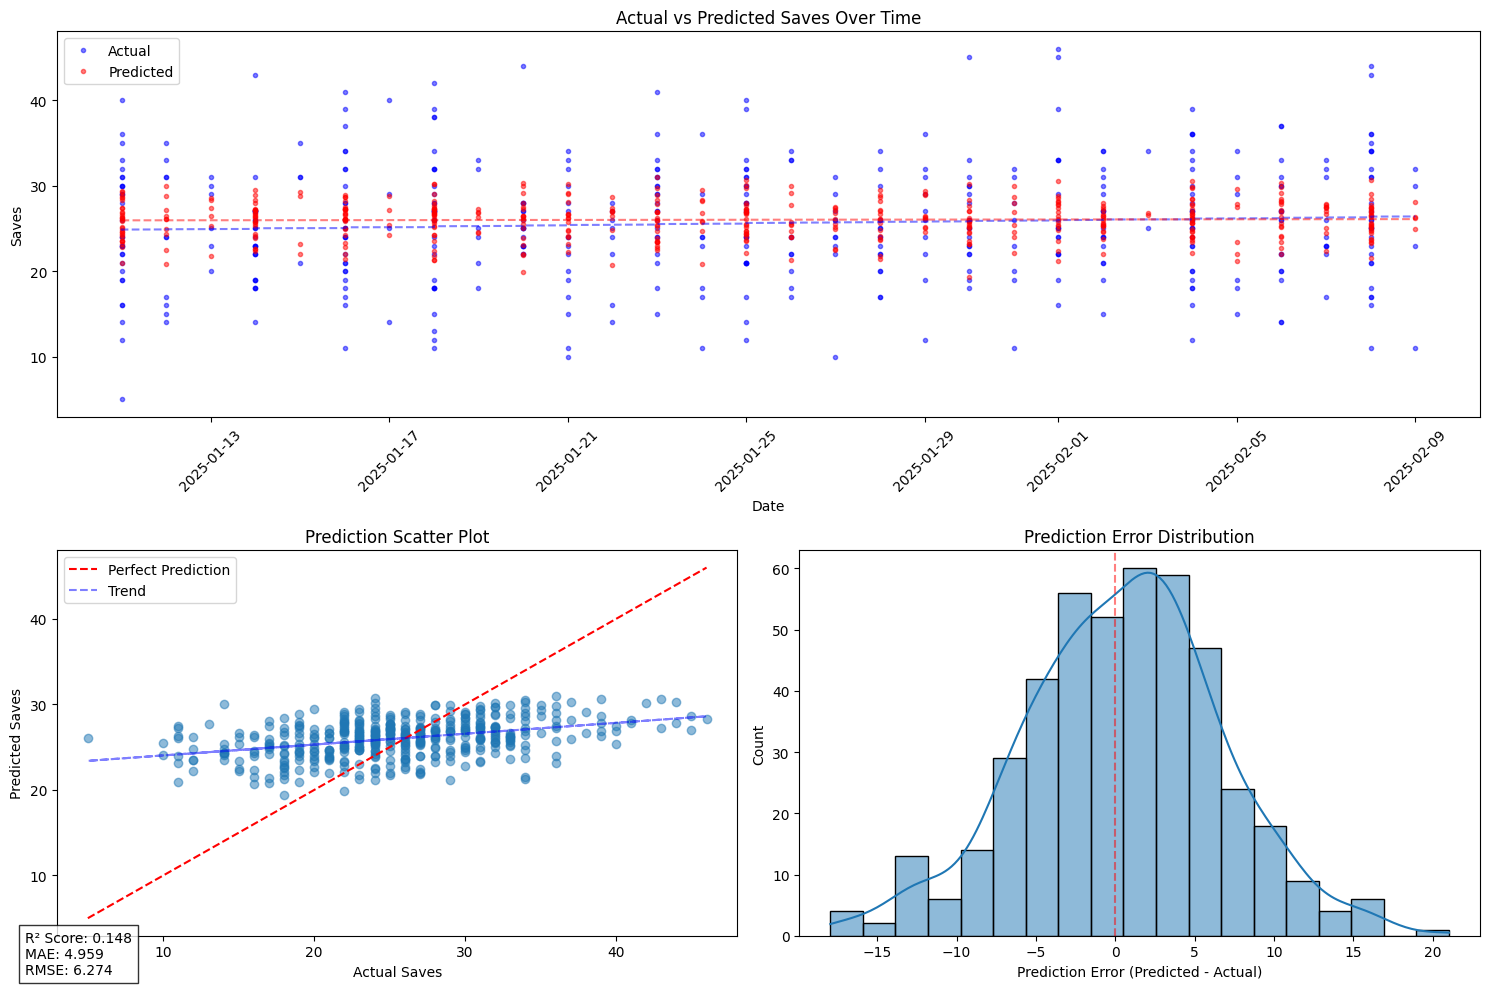


Error Statistics:
Mean Error: 0.432
Error Std Dev: 6.267
Error Range: [-17.954, 21.031]


In [219]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

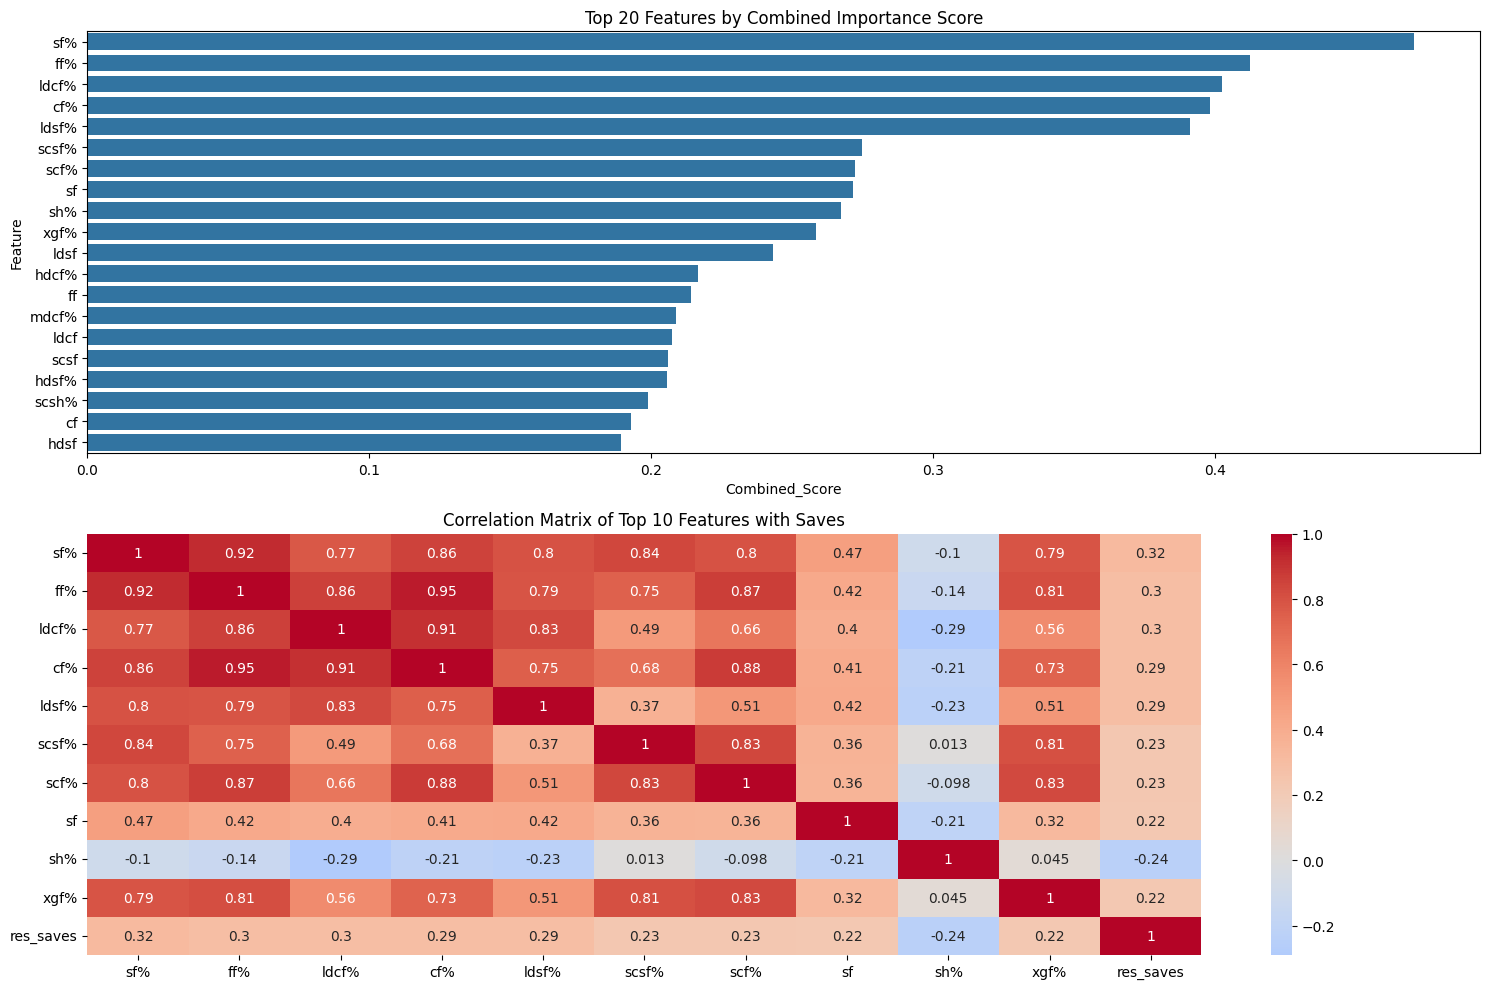


Top 20 Most Important Features for Predicting Saves:
   Feature  Combined_Score  Correlation  PCA_Importance  F_Score_Norm
9      sf%        0.470298     0.319283        0.091610      1.000000
6      ff%        0.412422     0.296439        0.092093      0.848735
51   ldcf%        0.402178     0.297103        0.056526      0.852907
3      cf%        0.397926     0.292074        0.080093      0.821611
54   ldsf%        0.390909     0.293452        0.049161      0.830113
21   scsf%        0.274788     0.230743        0.098201      0.495421
18    scf%        0.272262     0.230248        0.093363      0.493175
7       sf        0.271644     0.220101        0.146331      0.448500
59     sh%        0.267307     0.236927        0.041062      0.523931
15    xgf%        0.258403     0.220668        0.103606      0.450935
52    ldsf        0.243073     0.206444        0.130607      0.392169
29   hdcf%        0.216473     0.199923        0.082725      0.366771
4       ff        0.214149     0.184

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_features_for_saves_prediction(df):
    # Remove columns we don't want to consider as features
    exclude_cols = [
        'game_date', 'game_id', 'team', 'goalie_name', 'goalie_team', 'goalie_id', 
        'res_decision', 'res_saves', 'res_shots_against', 'res_save_pct', 'res_goals_against'
    ]
    
    # Convert boolean columns to int
    df['home'] = df['home'].astype(int)
    df['b2b'] = df['b2b'].astype(int)
    df['opp_b2b'] = df['opp_b2b'].astype(int)
    
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Create feature matrix and target vector
    X = df[feature_cols].copy()
    y = df['res_saves']
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 1. PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # 2. Direct correlation with target
    correlations = []
    for col in feature_cols:
        corr = df[col].corr(y)
        correlations.append((col, abs(corr)))
    
    correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
    correlation_df = correlation_df.sort_values('Correlation', ascending=False)
    
    # 3. Feature selection using f_regression
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_scaled, y)
    f_scores = selector.scores_
    
    # Combine all feature importance metrics
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'PCA_Importance': np.abs(pca.components_[0]),
        'Correlation': [abs(df[col].corr(y)) for col in feature_cols],
        'F_Score': f_scores
    })
    
    # Normalize F-scores
    feature_importance_df['F_Score_Norm'] = feature_importance_df['F_Score'] / feature_importance_df['F_Score'].max()
    
    # Calculate combined importance score
    feature_importance_df['Combined_Score'] = (
        feature_importance_df['PCA_Importance'] + 
        feature_importance_df['Correlation'] + 
        feature_importance_df['F_Score_Norm']
    ) / 3
    
    feature_importance_df = feature_importance_df.sort_values('Combined_Score', ascending=False)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Top 20 Features by Combined Score
    plt.subplot(2, 1, 1)
    sns.barplot(data=feature_importance_df.head(20), 
                x='Combined_Score', y='Feature')
    plt.title('Top 20 Features by Combined Importance Score')
    
    # Plot 2: Correlation Matrix of Top Features with Target
    plt.subplot(2, 1, 2)
    top_features = feature_importance_df.head(10)['Feature'].tolist() + ['res_saves']
    correlation_matrix = df[top_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Top 10 Features with Saves')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nTop 20 Most Important Features for Predicting Saves:")
    print(feature_importance_df[['Feature', 'Combined_Score', 'Correlation', 'PCA_Importance', 'F_Score_Norm']].head(20))
    
    # Group features by type
    feature_groups = {
        'Goalie Performance': [col for col in feature_cols if col.startswith('g_')],
        'Team Stats': ['cf%', 'ff%', 'sf%', 'gf%', 'xgf%', 'scf%', 'hdcf%'],
        'Game Context': ['home', 'b2b', 'opp_b2b'],
        'Shot Quality': ['hdsv%', 'mdsv%', 'ldsv%']
    }
    
    print("\nAverage Importance by Feature Group:")
    for group, features in feature_groups.items():
        group_importance = feature_importance_df[
            feature_importance_df['Feature'].isin(features)
        ]['Combined_Score'].mean()
        print(f"{group}: {group_importance:.4f}")
    
    return feature_importance_df

# Run the analysis
feature_importance_df = analyze_features_for_saves_prediction(processed_df)

Starting grid search...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

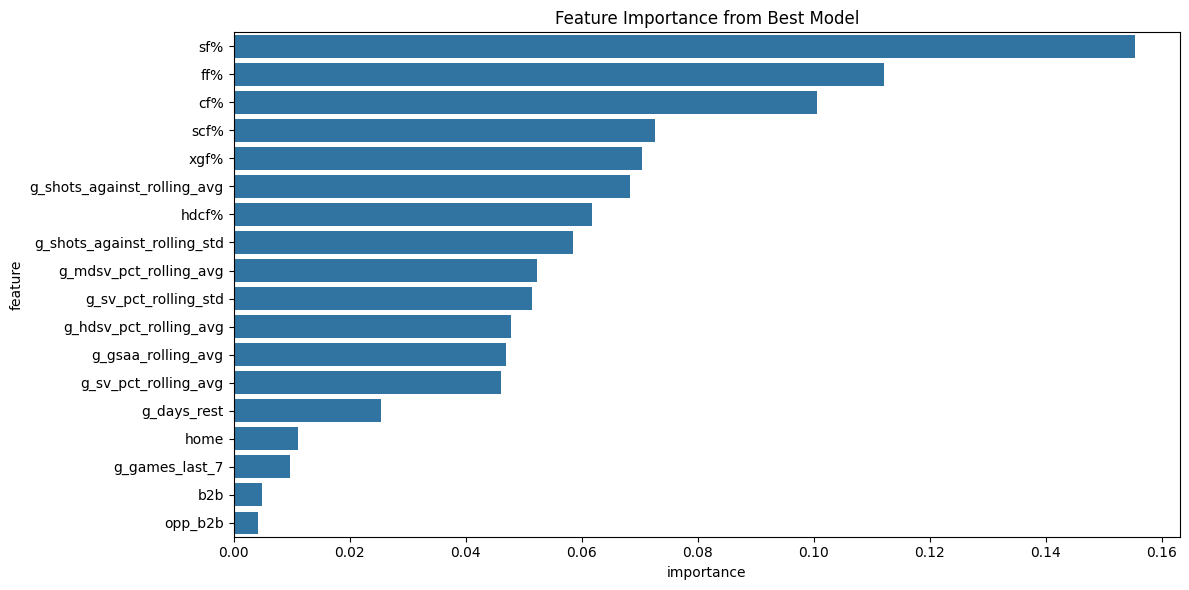

In [217]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search
print("Starting grid search...")
grid_search.fit(X_scaled, y)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\nTop 5 parameter combinations:")
top_5_params = cv_results[['params', 'mean_test_score', 'std_test_score']].head()
top_5_params['rmse'] = np.sqrt(-top_5_params['mean_test_score'])
print(top_5_params)

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Train final model with best parameters
best_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_scaled, y)

# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance from best model:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

In [4]:
def predict_next_game(goalie_history, model, scaler, window_size=10):
    """Predict save percentage for next game"""
    X, _ = prepare_features(goalie_history, window_size)
    X_latest = X.iloc[[-1]]  # Get most recent game's features
    X_scaled = scaler.transform(X_latest)
    
    predicted_sv = model.predict(X_scaled)[0]
    return predicted_sv

def calculate_performance_scalar(predicted_sv, league_avg_sv=0.910):
    """Convert predicted save percentage to performance scalar"""
    sv_diff = predicted_sv - league_avg_sv
    return 1 - sv_diff

In [ ]:
# Now let's evaluate the model
processed_data = prepare_game_data(goalie_stats)
model, scaler, metrics = train_model(processed_data)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")

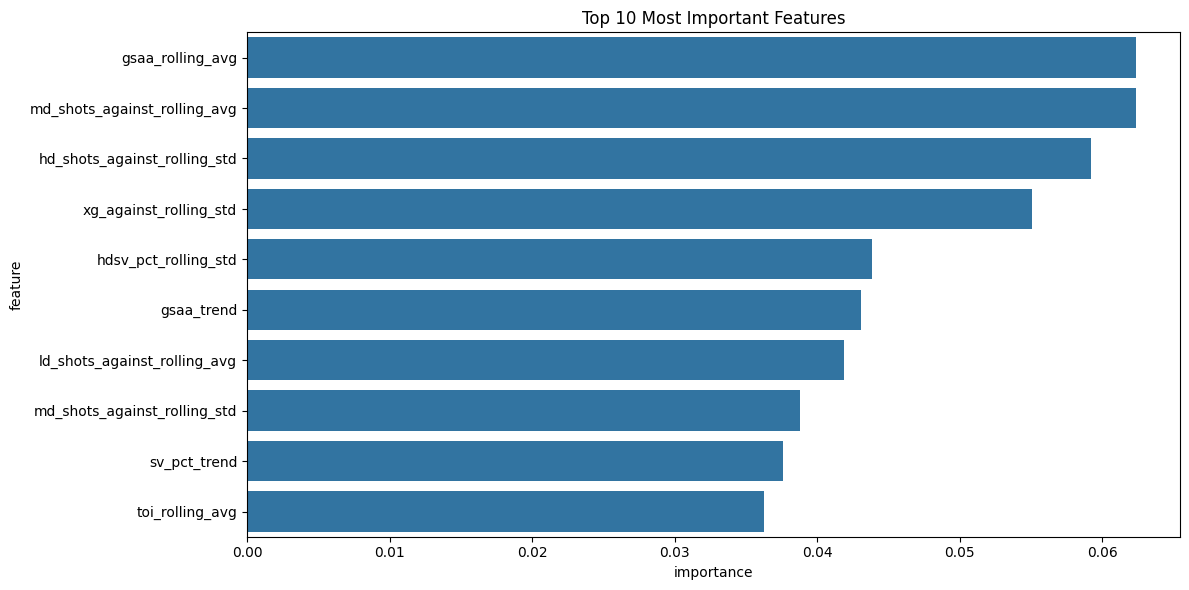

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': list(metrics['feature_importance'].keys()),
    'importance': list(metrics['feature_importance'].values())
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Original data length: 21
Predictions length: 21
X_scaled shape: (21, 28)


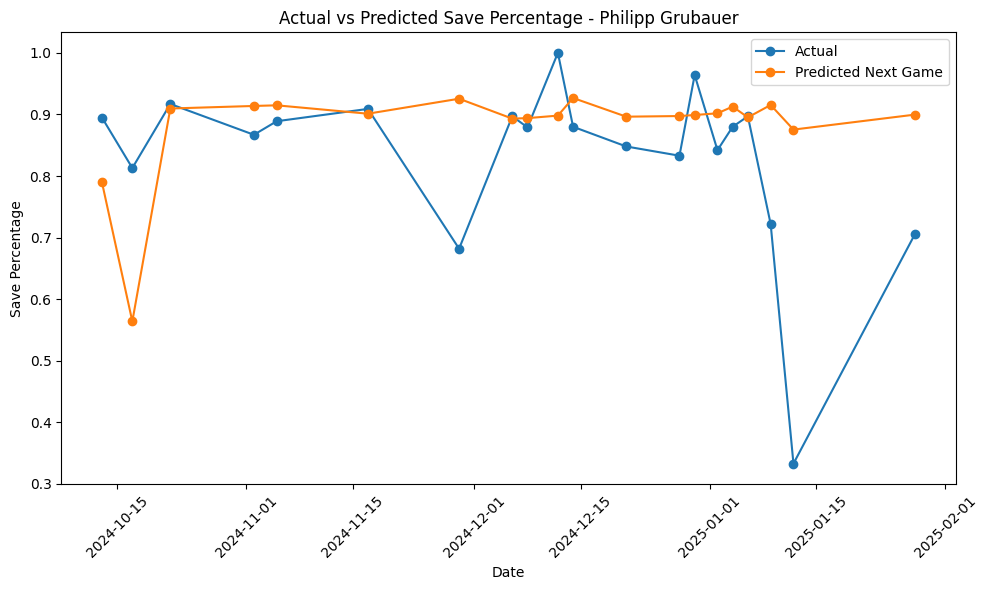


Predicted save percentage for Philipp Grubauer's next game: 0.837


In [ ]:
# Plot actual vs predicted values for a specific goalie
goalie_name = 'Philipp Grubauer'
goalie_data = processed_data[processed_data['player'] == goalie_name].copy()  # Make a copy
X, processed_df = prepare_features(goalie_data)
X_scaled = scaler.transform(X)
predictions = model.predict(X_scaled)

# Print dimensions to debug
print(f"Original data length: {len(goalie_data)}")
print(f"Predictions length: {len(predictions)}")
print(f"X_scaled shape: {X_scaled.shape}")

# Create the plot with aligned data
plt.figure(figsize=(10, 6))
# Use the same date range for both actual and predicted values
dates = goalie_data['date'].iloc[:-1]  # Remove last date
actual_values = goalie_data['sv_pct'].iloc[:-1]  # Remove last actual value

plt.plot(dates, actual_values, label='Actual', marker='o')
plt.plot(dates, predictions[:-1], label='Predicted Next Game', marker='o')
plt.title(f'Actual vs Predicted Save Percentage - {goalie_name}')
plt.xlabel('Date')
plt.ylabel('Save Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the prediction for the next game
print(f"\nPredicted save percentage for {goalie_name}'s next game: {predictions[-1]:.3f}")

In [46]:
performance_scalar

1.0187401996962557

In [47]:
g

NameError: name 'g' is not defined